In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

paths = glob('/Users/bmmorris/data/kepler7/*slc.fits')

In [72]:
a = 0.06067
per = 4.8854892
rp = 0.08294
t0 = 2454967.27687
duration = 0.213804

In [30]:
from astropy.io import fits

times = []
fluxes = []
for path in paths: 
    f = fits.getdata(path)
    times.append(f['TIME'] + 2454833)
    
    norm_sap = f['SAP_FLUX']/np.nanmedian(f['SAP_FLUX'])
    
    not_nan = ~np.isnan(norm_sap)
    norm_sap /= np.polyval(np.polyfit(f['TIME'][not_nan], norm_sap[not_nan], 3), f['TIME'])
    
    fluxes.append(norm_sap)

times = np.concatenate(times)
fluxes = np.concatenate(fluxes)

times = times[~np.isnan(fluxes)]
fluxes = fluxes[~np.isnan(fluxes)]

(0.99, 1.005)

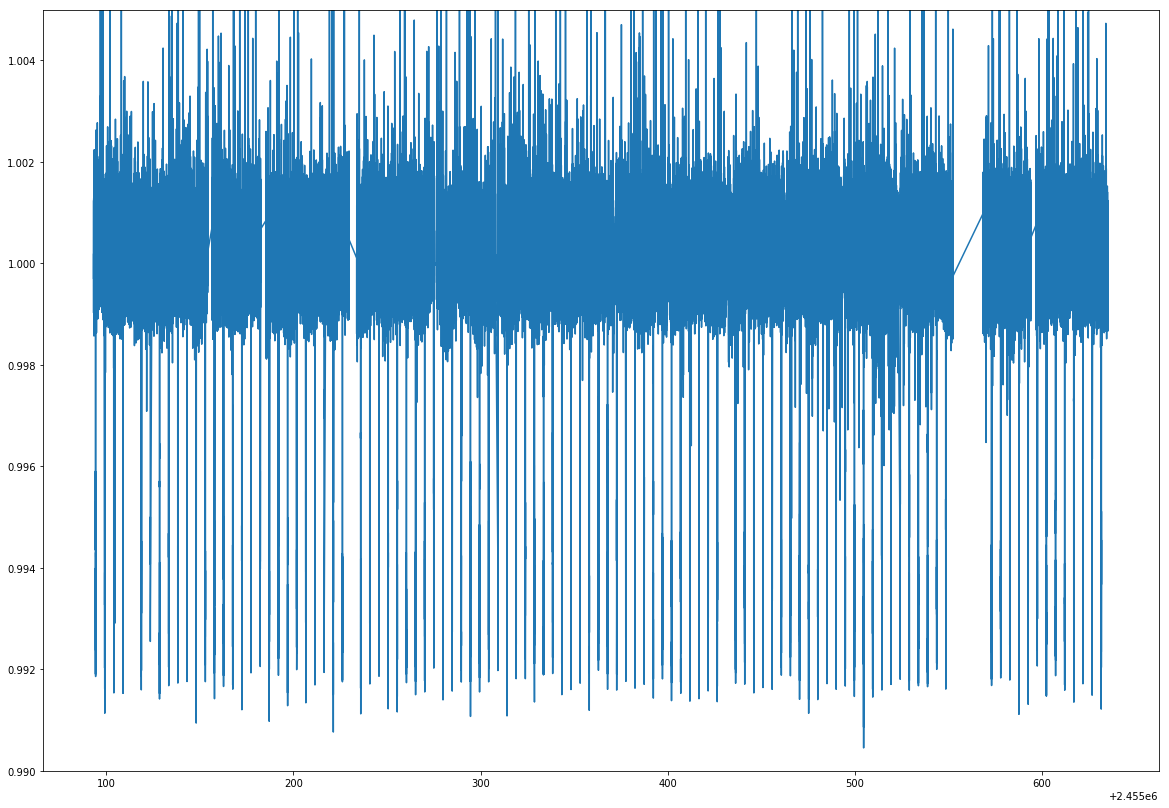

In [31]:
plt.figure(figsize=(20, 14))
plt.plot(times, fluxes)
plt.ylim([0.99, 1.005])

In [65]:
phases = ((times - t0) % per) / per
phases[phases > 0.5] -= 1

In [66]:
mask_transit = np.logical_not(np.abs(phases) < 1.05*duration/per)
mask_eclipse = np.logical_not(np.abs(phases) > 0.5 - 1.05*duration/per)
mask = mask_transit #& mask_eclipse

In [67]:
phases[phases < 0] += 1

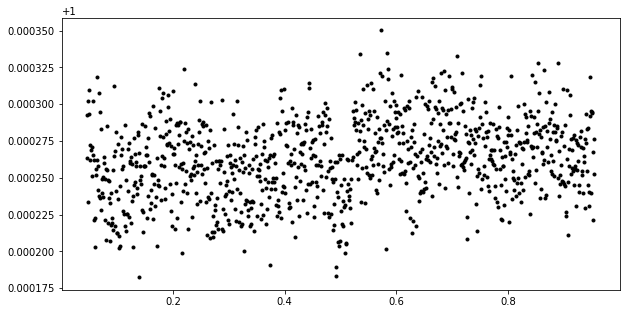

In [223]:
from scipy.stats import binned_statistic

bs = binned_statistic(phases[mask], fluxes[mask], bins=1000, statistic='median')

bs2 = binned_statistic(phases[mask], fluxes[mask], bins=100, statistic='median')

bincenters = 0.5*(bs.bin_edges[1:] + bs.bin_edges[:-1])
binned_time, binned_flux = bincenters, bs.statistic

bincenters2 = 0.5*(bs2.bin_edges[1:] + bs2.bin_edges[:-1])
binned_time2, binned_flux2 = bincenters2, bs2.statistic

plt.figure(figsize=(10, 5))
# plt.plot(phases, fluxes, '.', alpha=0.001)
plt.plot(binned_time, binned_flux, 'k.')

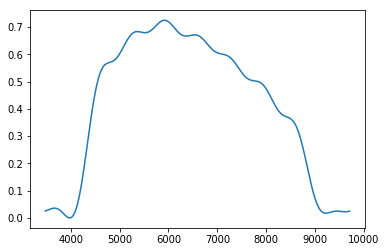

In [224]:
from tynt import FilterGenerator
f = FilterGenerator()
filt = f.reconstruct('Kepler/Kepler.K')
plt.plot(filt.wavelength, filt.transmittance)

In [225]:
import spiderman as sp
spider_params = sp.ModelParams(brightness_model="zhang")
spider_params.n_layers = 5

spider_params.t0 = 0               # Central time of PRIMARY transit [days]
spider_params.per = 1       # Period [days]
spider_params.a_abs = a       # The absolute value of the semi-major axis [AU]
spider_params.inc = 85.161            # Inclination [degrees]
spider_params.ecc = 0.0              # Eccentricity
spider_params.w = 90                 # Argument of periastron
spider_params.rp = rp            # Planet to star radius ratio
spider_params.a = 6.637              # Semi-major axis scaled by stellar radius
spider_params.p_u1 = 0               # Planetary limb darkening parameter
spider_params.p_u2 = 0               # Planetary limb darkening parameter
spider_params.xi = 0     # Ratio of radiative to advective timescale
spider_params.T_n = 2000     # Temperature of nightside
spider_params.delta_T = 1000  # Day-night temperature contrast
spider_params.T_s = 5933    # Temperature of the star
spider_params.l1 = 400e-9       # The starting wavelength in meters
spider_params.l2 = 900e-9       # The ending wavelength in meters
spider_params.limb_dark = 'quadratic'
spider_params.u = [0.4, 0.2]
spider_params.fp = 1e-5
spider_params.t_secondary = 0.5

In [226]:
from batman import TransitModel

eclipse = TransitModel(spider_params, binned_time, transittype='secondary').light_curve(spider_params)
eclipse -= eclipse.min()

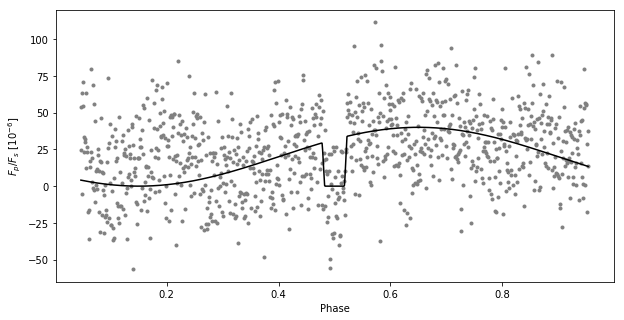

In [228]:
during_eclipse = np.abs(binned_time - 0.5) < duration/per/2

binned_flux -= np.median(binned_flux[during_eclipse])

scale = 2
lc = -scale*np.cos(2*np.pi*(binned_time - 0.15)) + scale

plt.figure(figsize=(10, 5))
# plt.plot(phases, fluxes, '.', alpha=0.001)
plt.plot(binned_time, 1e6 * binned_flux, '.', color='gray')
plt.plot(binned_time,  1e6*eclipse * lc, 'k')
plt.xlabel('Phase')
plt.ylabel('$F_p/F_s$ [10$^{-6}$]')
plt.savefig('plots/phase_curve.png', bbox_inches='tight', dpi=200)